# RUV-III-C

References:

https://github.com/CMRI-ProCan/RUV-III-C

https://www.nature.com/articles/s41467-020-17641-3#Sec11

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import scp.utils as utils
import scp.benchmark_models as bm

np.random.seed(0)

## 1. Data loading

In [2]:
adata = sc.read_h5ad("../../data/processed/poulos2020.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 1527 × 18114
    obs: 'Filename', 'Filetype', 'Information', 'File Name', 'Date', 'Sample', 'Instrument', 'Replicate', 'Day', 'PseudoReplicate_2', 'PseudoReplicate_3', 'PseudoReplicate_4', 'PseudoReplicate_5', 'PseudoReplicate_6', 'day', 'method', 'sample', 'ratio', 'ovary', 'prostate', 'yeast', 'hek293t', 'control', 'sample_no'
    var: 'Protein', 'Peptide', 'ModifiedPeptide', 'species'
    layers: 'raw'

In [4]:
print(f"Replicates:\n{adata.obs['Sample'].value_counts()}")

Replicates:
Sample
4. 12.5% Ovary / 50% Prostate / 37.5% Yeast       233
5. 25% Ovary / 50% Prostate / 25% Yeast           232
3. 6.25% Ovary / 50% Prostate / 43.75% Yeast      230
2. 3.125% Ovary / 50% Prostate / 46.875% Yeast    225
6. 50% Ovary / 50% Prostate / 0% Yeast            154
7. 50% Ovary / 0% Prostate / 50% Yeast            153
8. HEK control cells                              151
1. 0% Ovary / 50% Prostate / 50% Yeast            149
Name: count, dtype: int64


> To do so, we randomly partitioned the technical replicates of each of the eight sample types into groups of triplicates acquired on different instruments, and we then declared as technical replicates only those acquisitions corresponding to one of these groups. In effect, we have altered our definition of technical replicates in order to mimic a real-world scenario, whereby we normalise data with RUV-III-C using technical replicates acquired on different instruments at varying times from last clean.

In [5]:
pseudoreplicates = adata.obs["PseudoReplicate_3"].value_counts()

print(f"Pseudoreplicates | Triplicates: {np.sum(pseudoreplicates == 3)}, Other: {np.sum(pseudoreplicates != 3)}")

Pseudoreplicates | Triplicates: 488, Other: 32


For some reason not all pseudoreplicates are triplicates.

> Reptides were next identified that were inconsistently observed across the study. To do so, peptides were retained if they were observed in more than 10% of replicate samples from at least one of Samples 1–7. [...]  17,054 peptides were retained.

In [6]:
samples = adata.obs["Sample"].cat.categories
samples1_7 = [sample for sample in samples if sample[0] != "8"]

In [7]:
pep_obs_max = np.zeros(adata.n_vars)

for sample in samples1_7:
    adata2 = adata[adata.obs["Sample"] == sample]
    pep_obs = 1 - np.isnan(adata2.layers["raw"]).sum(0) / adata2.n_obs
    pep_obs_max = np.maximum(pep_obs_max, pep_obs)

adata.var["peptide_obs_max"] = pep_obs_max
adata = adata[:, adata.var["peptide_obs_max"] > 0.1].copy()

Hmm... they retained 17,054 peptides.

In [8]:
print(f"Number of peptides: {adata.n_vars}")

Number of peptides: 17178


> This experimental design comprised eight sample types, with data for each obtained from many replicate MS runs. Seven of these sample types contained a variable yeast-prostate-ovary mixture. For this reason, there were no endogenous peptides that could be regarded as negative controls in the usual sense. Instead, we obtained negative control peptides by scaling peptides from yeast proteins on the log2-scale within each sample type group, so that the mean intensity is identical between different sample types

In [9]:
for sample in samples:
    yeast_idx = np.where(adata.var["species"] == "YEAST")[0]
    sample_idx = np.where(adata.obs["Sample"] == sample)[0]

    a, b = np.meshgrid(sample_idx, yeast_idx)
    adata.layers["raw"][a, b] /= np.nanmean(adata.layers["raw"][a, b], axis=0)

> All we need to apply RUV-III-C satisfactorily for peptide p is that in the acquisitions that give a non-missing intensity for peptide p, the negative control yeast peptides also give non-missing intensities. For each peptide, we used variable numbers of negative controls up to a total of 1,622 peptides, which was the total number of peptides derived from yeast proteins that were identified in our study.

In [10]:
n_yeast = np.sum(adata.var["species"] == "YEAST")
print(f"Number of yeast genes: {n_yeast}")

Number of yeast genes: 1693


>  In order for RUV-III with k factors to be successfully applied to a data matrix Y, the rows of M less columns of M must be ≥k. This condition must hold for each peptide, and so peptides were only retained where the number of runs recording non-missing intensities less the number of biological samples in which a non-missing intensity occurs was ≥k.

In [11]:
# @TODO: what do they mean?

Do RUV.

In [12]:
adata = sc.read_h5ad("../../data/processed/poulos2020.h5ad")

In [13]:
adata.X = adata.layers["raw"].copy()

In [14]:
# @TODO: remove this block
#adata = adata[:100, :] # The algorithm is slow on my machine. This size takes 50 seconds on my machine. Full size is 40 mins.
#adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)]

In [15]:
r_adata = utils.prepare_anndata_for_R(adata)

In [16]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [17]:
%%R -i r_adata
library(RUVIIIC)

X <- assay(r_adata, "X")

obs_names <- colnames(X)
obs       <- colData(r_adata)

var_names <- rownames(X)
var       <- rowData(r_adata)

Y <- t(X)
k <- 20

col <- colData(r_adata)

M <- model.matrix(~ PseudoReplicate_3 - 1, data=obs)

controls  <- var_names[var$species == "YEAST"]
controls  <- controls[!is.na(controls)] # for some reason 'controls' contains NA now.

toCorrect <- var_names

result <- RUVIII_C_Varying(k=k, Y=Y, M=M, toCorrect=toCorrect, potentialControls=controls)

Loading required package: RSpectra
Loading required package: progress
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


In [18]:
result = robjects.r("result")

Let's visualize the result.

In [19]:
from scp.benchmark_models import impute_knn

In [20]:
adata.layers["RUVIII_C"] = result.copy()

In [21]:
# this should not be necessary... But for some reason there are peptides with only NaN values after applying RUVIII
print(f"no. of peptides only with NaN columns: {np.sum(np.all(np.isnan(adata.layers['RUVIII_C']), axis=0))}")

# ... so override those with the original values
mask = np.isnan(adata.layers["RUVIII_C"])
adata.layers["RUVIII_C"][mask] = adata.layers["raw"][mask]

no. of peptides only with NaN columns: 11705


In [22]:
adata.layers["RUVIII_C_imp"] = impute_knn(adata, "RUVIII_C")

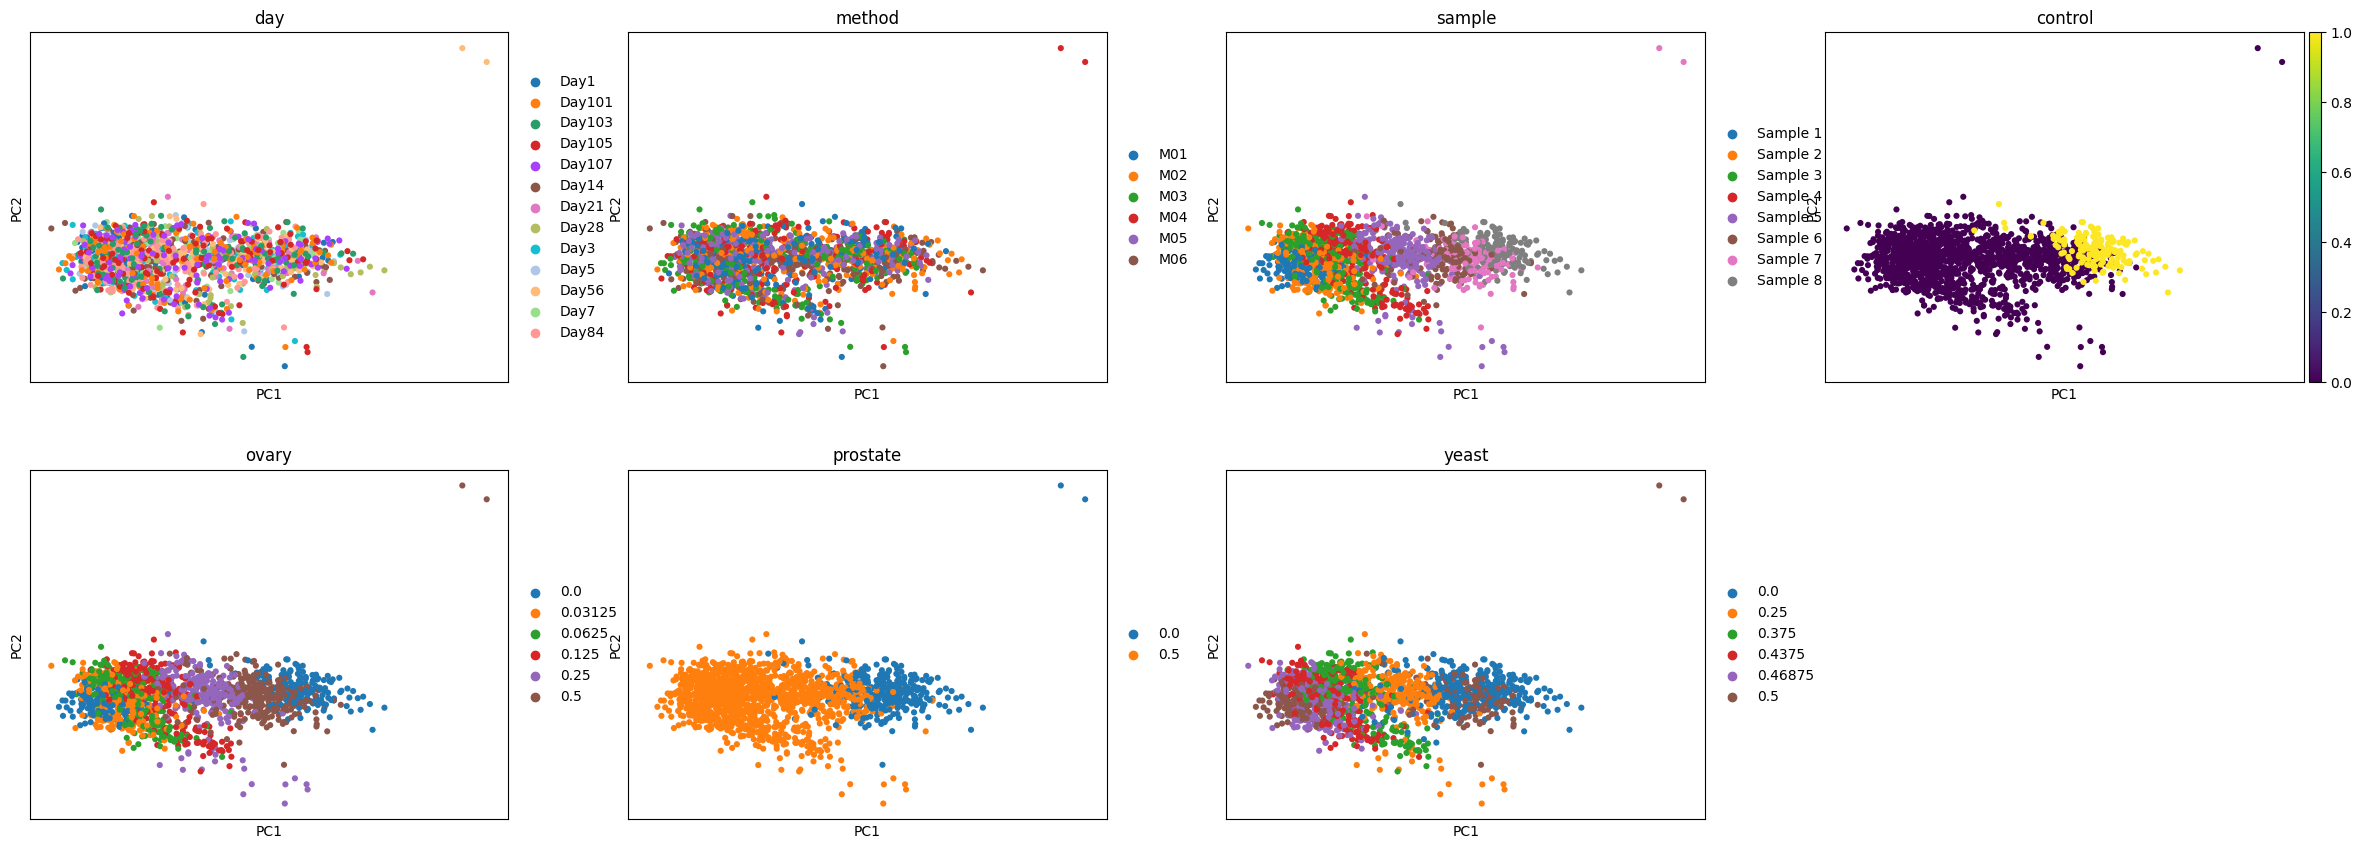

In [23]:
adata.X = adata.layers["RUVIII_C_imp"].copy()

sc.pp.pca(adata)

sc.pl.pca(
    adata, 
    color=["day", "method", "sample", "control", "ovary", "prostate", "yeast"],
    vmin="p01", vmax="p99",
)

In [24]:
adata.write("../../data/processed/poulos2020_RUVIII_C.h5ad")